This notebook demonstrates how a DAG can be used in combination with the assignment of a distribution to each node and a weight to each edge to create a linear SCM.

In [1]:
import sys
import time

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from y0.graph import NxMixedGraph
from y0.dsl import V1, V2, V3, V4, V5, V6
from y0.simulation import simulate, example_graph, example_generators

In [2]:
print(sys.version)

3.11.7 (main, Dec  4 2023, 18:10:11) [Clang 15.0.0 (clang-1500.1.0.2.5)]


In [3]:
print(time.asctime())

Mon Mar 18 08:09:30 2024


In [4]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")

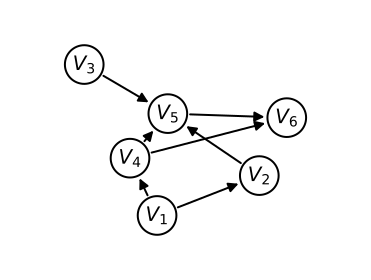

In [5]:
example_graph.draw(prog="neato")

In [6]:
example_graph.to_linear_scm_latex()

'\\begin{align*}V_1 &= \\epsilon_{V_1} \\\\\n V_3 &= \\epsilon_{V_3} \\\\\n V_2 &= V_{1} \\beta_{V_1,V_2} + \\epsilon_{V_2} \\\\\n V_4 &= V_{1} \\beta_{V_1,V_4} + \\epsilon_{V_4} \\\\\n V_5 &= V_{2} \\beta_{V_2,V_5} + V_{3} \\beta_{V_3,V_5} + V_{4} \\beta_{V_4,V_5} + \\epsilon_{V_5} \\\\\n V_6 &= V_{4} \\beta_{V_4,V_6} + V_{5} \\beta_{V_5,V_6} + \\epsilon_{V_6} \\\\\\end{align*}'

## Simulating Data

It's possible to simulate data using a linear structural causal model (SCM) given the following:

1. A directed acyclic graph (DAG) structure
2. A scalar weight for each edge in the DAG
3. A probability distribution for each node

In [7]:
df, fits = simulate(example_graph, generators=example_generators, trials=5000)

Simulation:   0%|          | 0.00/5.00k [00:00<?, ?trial/s]

Ultimately the simulation provides _trials_ number of data points:

In [8]:
df

,V1,V3,V2,V4,V5,V6
0,0.962798,0.155703,2.718189,1.214573,5.650712,1.126347
1,0.147480,-0.997892,-1.139373,-1.103323,-1.271401,3.171274
2,0.960029,-0.949493,-0.894814,0.653612,-1.601573,1.286830
3,0.689227,0.928666,1.208475,-2.243475,1.349800,-5.018945
4,0.911267,0.348451,0.738285,-2.124696,0.263452,-0.215388
...,...,...,...,...,...,...
4995,-0.112185,0.086198,1.272555,-0.917124,-0.025022,4.314146
4996,-0.280054,-0.455051,1.696302,1.456665,2.335749,3.949990
4997,-0.506914,1.081459,-1.602472,-3.717907,-6.387989,-4.751844
4998,0.311815,-0.623489,-1.702156,1.765528,-2.972573,2.869946


The simulation also performs several calculations over each pair of variables:

1. What's the correlation coefficient ($r^2$) between the variables?
2. Are the variables d-separated (i.e., conditionally independent)?

In [9]:
def fits_to_frame(fits):
    param_df = pd.DataFrame(
        [
            (
                a.name,
                b.name,
                t.slope,
                t.intercept,
                t.r2,
                # t.edge,
                False if t.d_separation is None else t.d_separation.separated,
                None if t.d_separation is None else t.d_separation.conditions,
            )
            for (a, b), t in fits.items()
        ],
        columns=[
            "parent",
            "child",
            "slope",
            "intercept",
            "r2",
            "d_separated",
            "d_sep_cond",
        ],
    )
    return param_df

In [10]:
param_df = fits_to_frame(fits)
param_df

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,V1,V2,0.741752,-0.000215,0.121593,False,None
1,V1,V4,0.378855,-0.021707,0.012244,False,None
2,V5,V2,0.762889,-0.051950,0.141511,False,None
3,V5,V4,0.748971,-0.033080,0.353356,False,None
4,V6,V4,0.577776,-0.046400,0.113469,False,None
5,V5,V6,0.646993,-0.026673,0.225878,False,None
6,V5,V3,0.447402,-0.050443,0.032324,False,None
7,V1,V3,0.022652,0.008488,0.000171,True,()
8,V5,V1,0.773111,-0.054153,0.032118,True,"(V2, V4)"
9,V1,V6,0.439833,-0.061116,0.005609,True,"(V4, V5)"


The following plot demonstrates that variables that are d-separated (i.e., conditionally independent) have effectively no correlation.

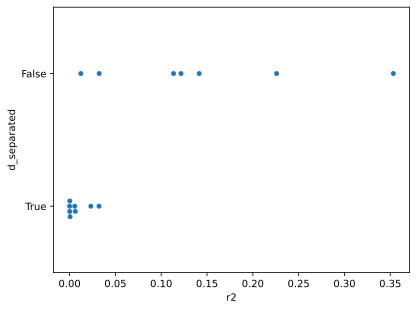

In [11]:
sns.swarmplot(data=param_df, y="d_separated", x="r2", orient="h")
plt.show()

In [12]:
from y0.algorithm.estimation.linear_scm import get_single_door

In [13]:
edge_parameters = get_single_door(example_graph, df)
edge_parameters

{(V1, V2): 0.7417515316004591,
 (V1, V4): 0.37885501103844416,
 (V2, V5): 0.7297490439274981,
 (V4, V5): 0.7356593987324656,
 (V4, V6): 0.5712815893130109,
 (V5, V6): 0.5789973449918264,
 (V3, V5): 0.44740193565273645}

## Backdoor example

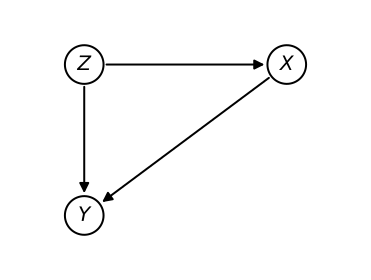

In [14]:
from y0.examples import backdoor_example

backdoor_example.graph.draw()

In [15]:
backdoor_example.graph.to_linear_scm_latex()

'\\begin{align*}Z &= \\epsilon_{Z} \\\\\n X &= Z \\beta_{Z,X} + \\epsilon_{X} \\\\\n Y &= X \\beta_{X,Y} + Z \\beta_{Z,Y} + \\epsilon_{Y} \\\\\\end{align*}'

In [16]:
backdoor_example.graph.nodes()

NodeView((Z, X, Y))

In [17]:
from functools import partial
from numpy.random import normal, uniform
from y0.dsl import X, Y, Z

backdoor_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z: partial(normal, loc=0.0, scale=1.0),
}

In [18]:
backdoor_df, backdoor_fits = simulate(
    backdoor_example.graph, generators=backdoor_generators, trials=5000
)

Simulation:   0%|          | 0.00/5.00k [00:00<?, ?trial/s]

In [19]:
backdoor_df.to_csv("../tests/test_algorithm/backdoor_example.csv")
backdoor_df

,Z,X,Y
0,-0.534371,-0.173188,1.248880
1,-0.786724,-1.412672,-0.263443
2,2.262908,2.505378,-0.133297
3,-1.458094,-1.374622,0.045801
4,-0.459916,-1.351905,-0.903170
...,...,...,...
4995,-1.008799,-1.434540,-1.639267
4996,1.158168,0.327960,-0.368513
4997,0.659000,-0.015264,0.461959
4998,-1.463462,-0.377061,1.028333


In [20]:
fits_to_frame(backdoor_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z,X,0.934492,-0.002609,0.720277,False,None
1,Z,Y,0.615638,-0.007487,0.211813,False,None
2,X,Y,0.600906,-0.005234,0.244662,False,None


In [21]:
backdoor_parameters = get_single_door(backdoor_example.graph, backdoor_df)
backdoor_parameters

{(Z, X): 0.9344915635673833,
 (Z, Y): 0.6156382767350169,
 (X, Y): 0.45184579597619673}

## Frontdoor example

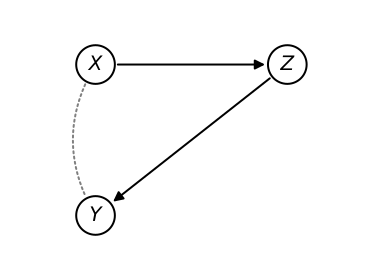

In [22]:
from y0.examples import frontdoor_example

frontdoor_example.graph.draw()

In [23]:
frontdoor_example.graph.to_linear_scm_latex()

'\\begin{align*}X &= \\epsilon_{X} + \\gamma_{X,Y} \\\\\n Z &= X \\beta_{X,Z} + \\epsilon_{Z} \\\\\n Y &= Z \\beta_{Z,Y} + \\epsilon_{Y} + \\gamma_{X,Y} \\\\\\end{align*}'

In [24]:
frontdoor_example.graph.nodes()

NodeView((X, Z, Y))

In [25]:
from functools import partial
from numpy.random import normal, uniform
from y0.dsl import X, Y, Z

frontdoor_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z: partial(normal, loc=0.0, scale=1.0),
}

In [26]:
frontdoor_df, frontdoor_fits = simulate(
    frontdoor_example.graph, generators=frontdoor_generators, trials=5000
)

Simulation:   0%|          | 0.00/5.00k [00:00<?, ?trial/s]

In [27]:
frontdoor_df.to_csv("../tests/test_algorithm/frontdoor_example.csv")
frontdoor_df

,X,Z,Y
0,-0.432021,0.013180,-1.512119
1,0.012225,1.498315,-1.145327
2,0.199635,-0.291354,-1.937875
3,0.821822,0.443788,1.538067
4,0.266238,0.856154,-0.873941
...,...,...,...
4995,0.744774,0.294470,-0.695019
4996,-0.407696,-0.317464,0.447574
4997,0.300477,0.958957,0.828841
4998,0.440801,-0.043663,0.752386


In [28]:
fits_to_frame(frontdoor_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z,X,0.560947,0.008065,0.096758,False,None
1,Z,Y,0.389670,0.002347,0.108335,False,None
2,X,Y,0.232326,0.005458,0.011842,False,None


In [29]:
frontdoor_parameters = get_single_door(frontdoor_example.graph, frontdoor_df)
frontdoor_parameters

{(X, Z): 0.5609473127997777, (Z, Y): 0.38704562044871343}

## Napkin example

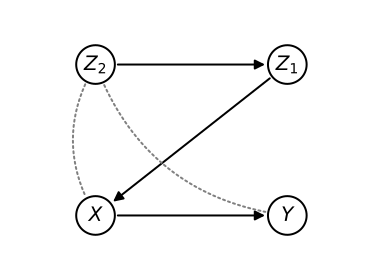

In [30]:
from y0.examples import napkin_example

napkin_example.graph.draw()

In [31]:
napkin_example.graph.to_linear_scm_latex()

'\\begin{align*}Z_2 &= \\epsilon_{Z_2} + \\gamma_{X,Z_2} + \\gamma_{Y,Z_2} \\\\\n Z_1 &= Z_{2} \\beta_{Z_2,Z_1} + \\epsilon_{Z_1} \\\\\n X &= Z_{1} \\beta_{Z_1,X} + \\epsilon_{X} + \\gamma_{X,Z_2} \\\\\n Y &= X \\beta_{X,Y} + \\epsilon_{Y} + \\gamma_{Y,Z_2} \\\\\\end{align*}'

In [32]:
napkin_example.graph.nodes()

NodeView((Z2, Z1, X, Y))

In [33]:
from functools import partial
from numpy.random import normal, uniform
from y0.dsl import X, Y, Z1, Z2

napkin_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z1: partial(normal, loc=0.0, scale=1.0),
    Z2: partial(normal, loc=0.0, scale=1.0),
}

In [34]:
napkin_df, napkin_fits = simulate(napkin_example.graph, generators=napkin_generators, trials=5000)

Simulation:   0%|          | 0.00/5.00k [00:00<?, ?trial/s]

In [35]:
napkin_df.to_csv("../tests/test_algorithm/napkin_example.csv")
napkin_df

,Z2,Z1,X,Y
0,-0.451993,-0.346183,-0.035927,0.995649
1,0.204098,0.044105,0.863200,1.081869
2,-0.904306,-2.244675,-1.225549,-1.383630
3,-0.523629,1.215038,1.069171,0.614644
4,1.827956,0.394783,-0.031047,0.471588
...,...,...,...,...
4995,-0.401022,0.772307,0.711171,0.403305
4996,0.425006,0.237382,0.693132,-1.371605
4997,-1.920952,-1.891171,-0.270788,-0.310452
4998,2.445184,1.001142,0.753203,-0.079066


In [36]:
fits_to_frame(napkin_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z1,Z2,0.393362,-0.014655,0.134881,False,None
1,Z1,X,0.331217,0.011266,0.274256,False,None
2,X,Y,0.521376,0.018688,0.087758,False,None
3,Z2,X,0.291386,0.026512,0.038962,False,None
4,Z1,Y,0.130940,-0.006198,0.021244,True,"(X, Z2)"
5,Z2,Y,0.041717,0.028498,0.002474,False,None


In [37]:
napkin_parameters = get_single_door(napkin_example.graph, napkin_df)
napkin_parameters

{(Z2, Z1): 0.3933615438203742, (Z1, X): 0.3298600000017826}